## Part 0: Environment Setup

Import all necessary libraries and configure the device for GPU/CPU computation.

In [1]:
# Core scientific libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from tqdm import tqdm

# Deep Learning: PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Custom modules
from data_loading import WaferDataLoader
from utility import (
    setup_model_and_loaders,
    train_model,
    evaluate_model,
    plot_training_history,
    train_from_config,
    train_all_models,
    hyperparameter_tuning
)
from config import (
    get_model_config,
    SIMPLE_NN_CONFIG,
    CNN_CONFIG,
    MLP_CONFIG,
    TRANSFER_LEARNING_CONFIG,
    print_all_configs,
    MODEL_CONFIGS,
    TUNING_GRIDS
)

# Model classes (import from your models file)
import sys
sys.path.append('.')
# Note: Adjust imports based on where your model classes are defined
# from models import SimpleNN, MLP, CNN, TransferLearning, LightweightCNN

print("✓ All imports successful!")

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n{'='*70}")
print("ENVIRONMENT CONFIGURATION".center(70))
print(f"{'='*70}")
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
print(f"{'='*70}\n")

Helper functions defined successfully!
✓ All imports successful!

                      ENVIRONMENT CONFIGURATION                       
Device: cuda
GPU: NVIDIA GeForce RTX 4060 Laptop GPU
CUDA Version: 12.1



## Part 1: Data Loading and Exploration

Load the wafer defect dataset and visualize its structure.

In [2]:
# Initialize data loader
print("Loading wafer defect dataset...")
loader = WaferDataLoader()

print("\n✓ Dataset loaded successfully!")
print(f"Dataset shape: {loader.X.shape}")
print(f"Labels shape: {loader.y_raw.shape}")
print(f"Number of classes: {len(np.unique(loader.y))}")

Loading wafer defect dataset...
Loading dataset from kagglehub cache...
✓ Dataset loaded successfully
  Wafer maps shape: (38015, 52, 52)
  Raw labels shape: (38015, 8)
✓ Labels converted to class indices
  Number of unique defect classes: 38

✓ Dataset loaded successfully!
Dataset shape: (38015, 52, 52)
Labels shape: (38015, 8)
Number of classes: 38
✓ Dataset loaded successfully
  Wafer maps shape: (38015, 52, 52)
  Raw labels shape: (38015, 8)
✓ Labels converted to class indices
  Number of unique defect classes: 38

✓ Dataset loaded successfully!
Dataset shape: (38015, 52, 52)
Labels shape: (38015, 8)
Number of classes: 38


In [3]:
# Print dataset summary
loader.print_summary()


WAFER DEFECT DATASET SUMMARY
Total samples: 38,015
Image dimensions: 52 × 52 pixels
Number of classes: 38
Pixel value range: 0.0000 - 3.0000
Mean pixel value: 1.0068
Mean pixel value: 1.0068
Std pixel value: 0.6932

Class distribution:
  Min samples per class: 149
  Max samples per class: 2000
  Mean samples per class: 1000.4
Std pixel value: 0.6932

Class distribution:
  Min samples per class: 149
  Max samples per class: 2000
  Mean samples per class: 1000.4


c:\Users\akash\OneDrive - University of Florida\wafer\data_loading.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=self.y, palette='viridis')


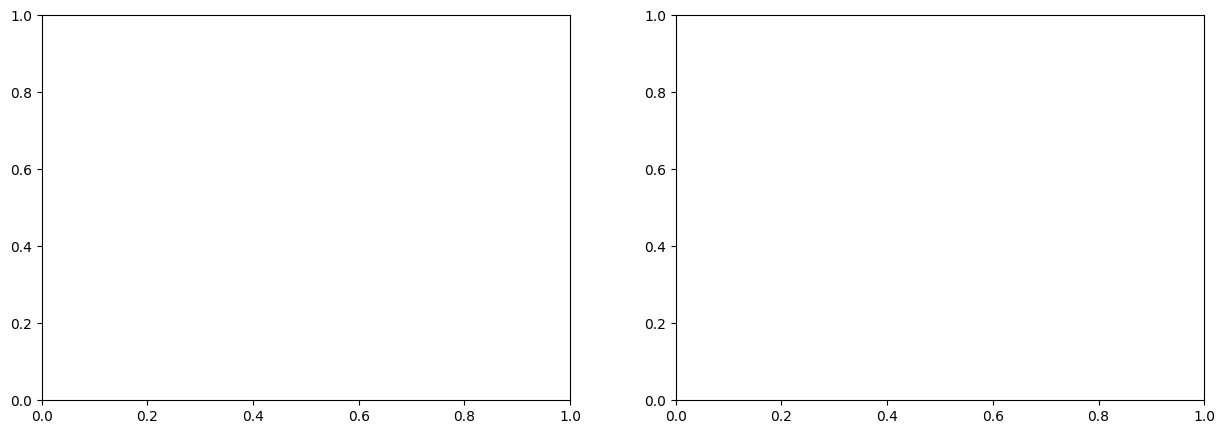

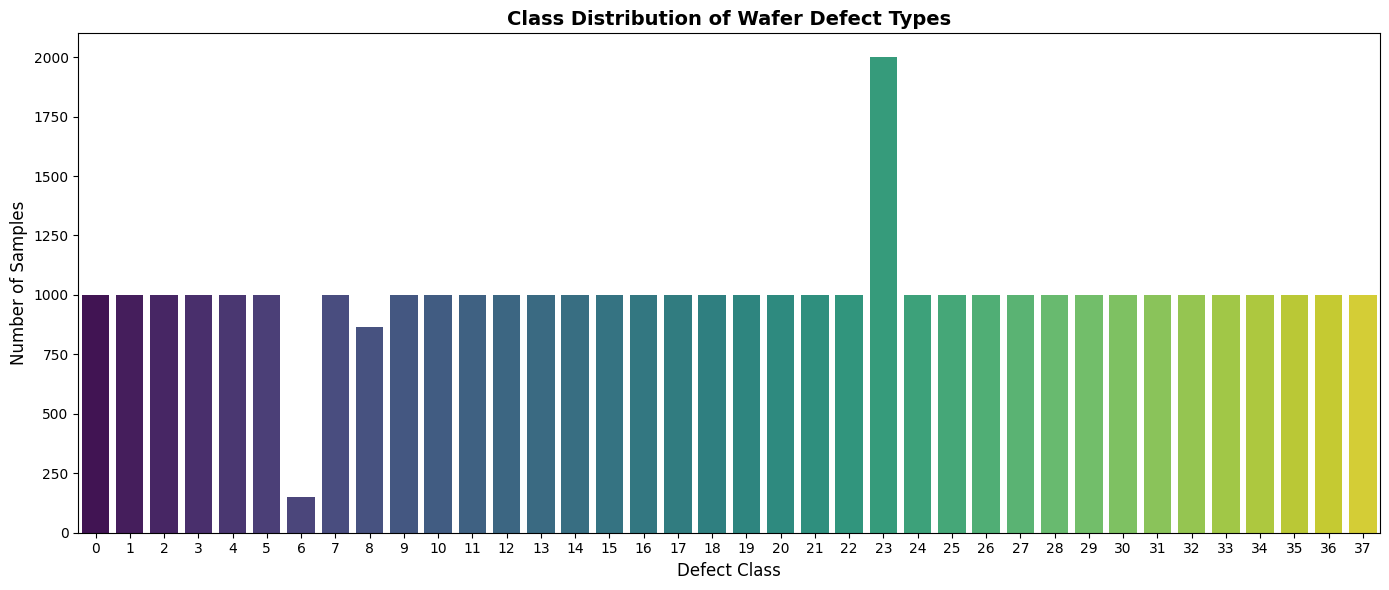

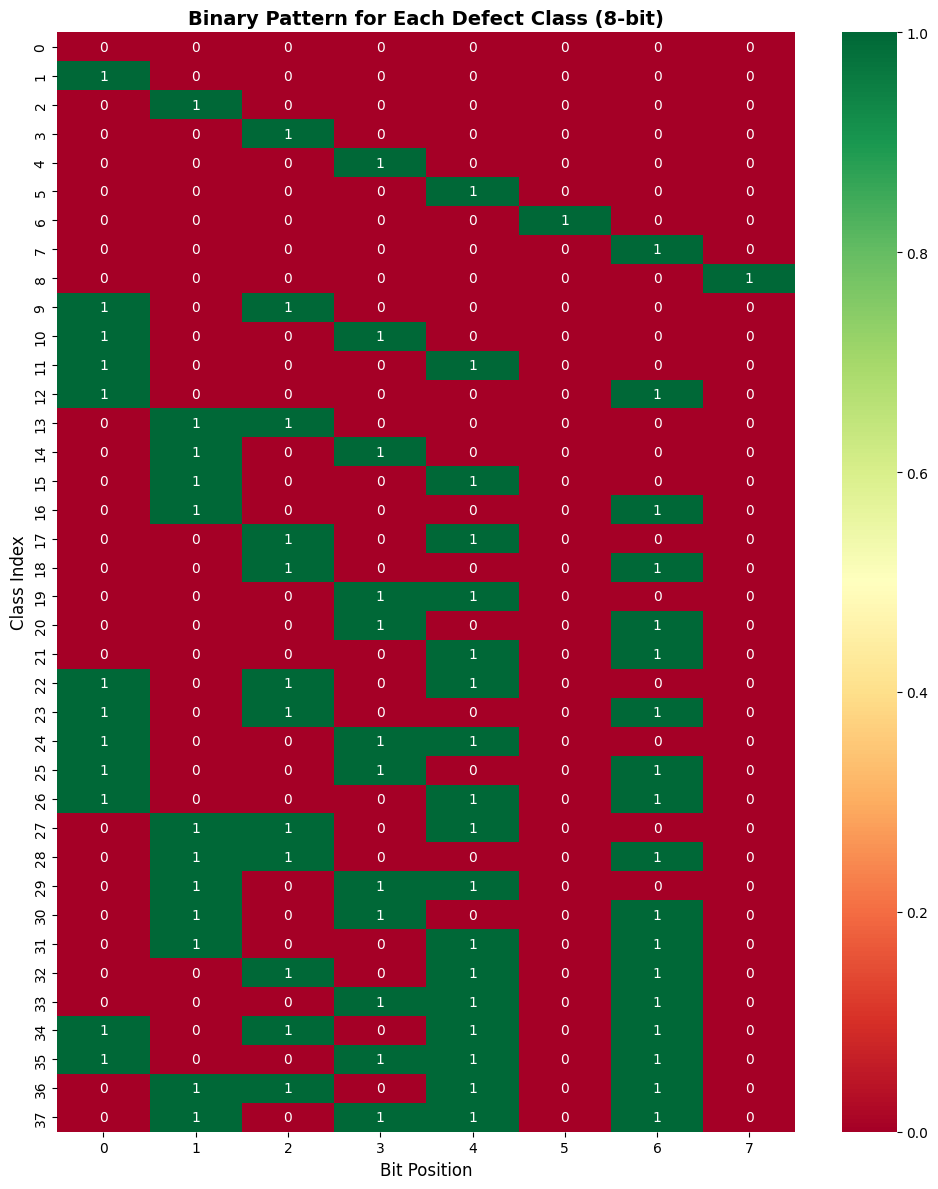

<Figure size 640x480 with 0 Axes>

In [4]:
# View class distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar plot
ax = axes[0]
loader.plot_class_distribution()

# Pattern heatmap
ax = axes[1]
loader.plot_pattern_heatmap()

plt.tight_layout()
plt.show()

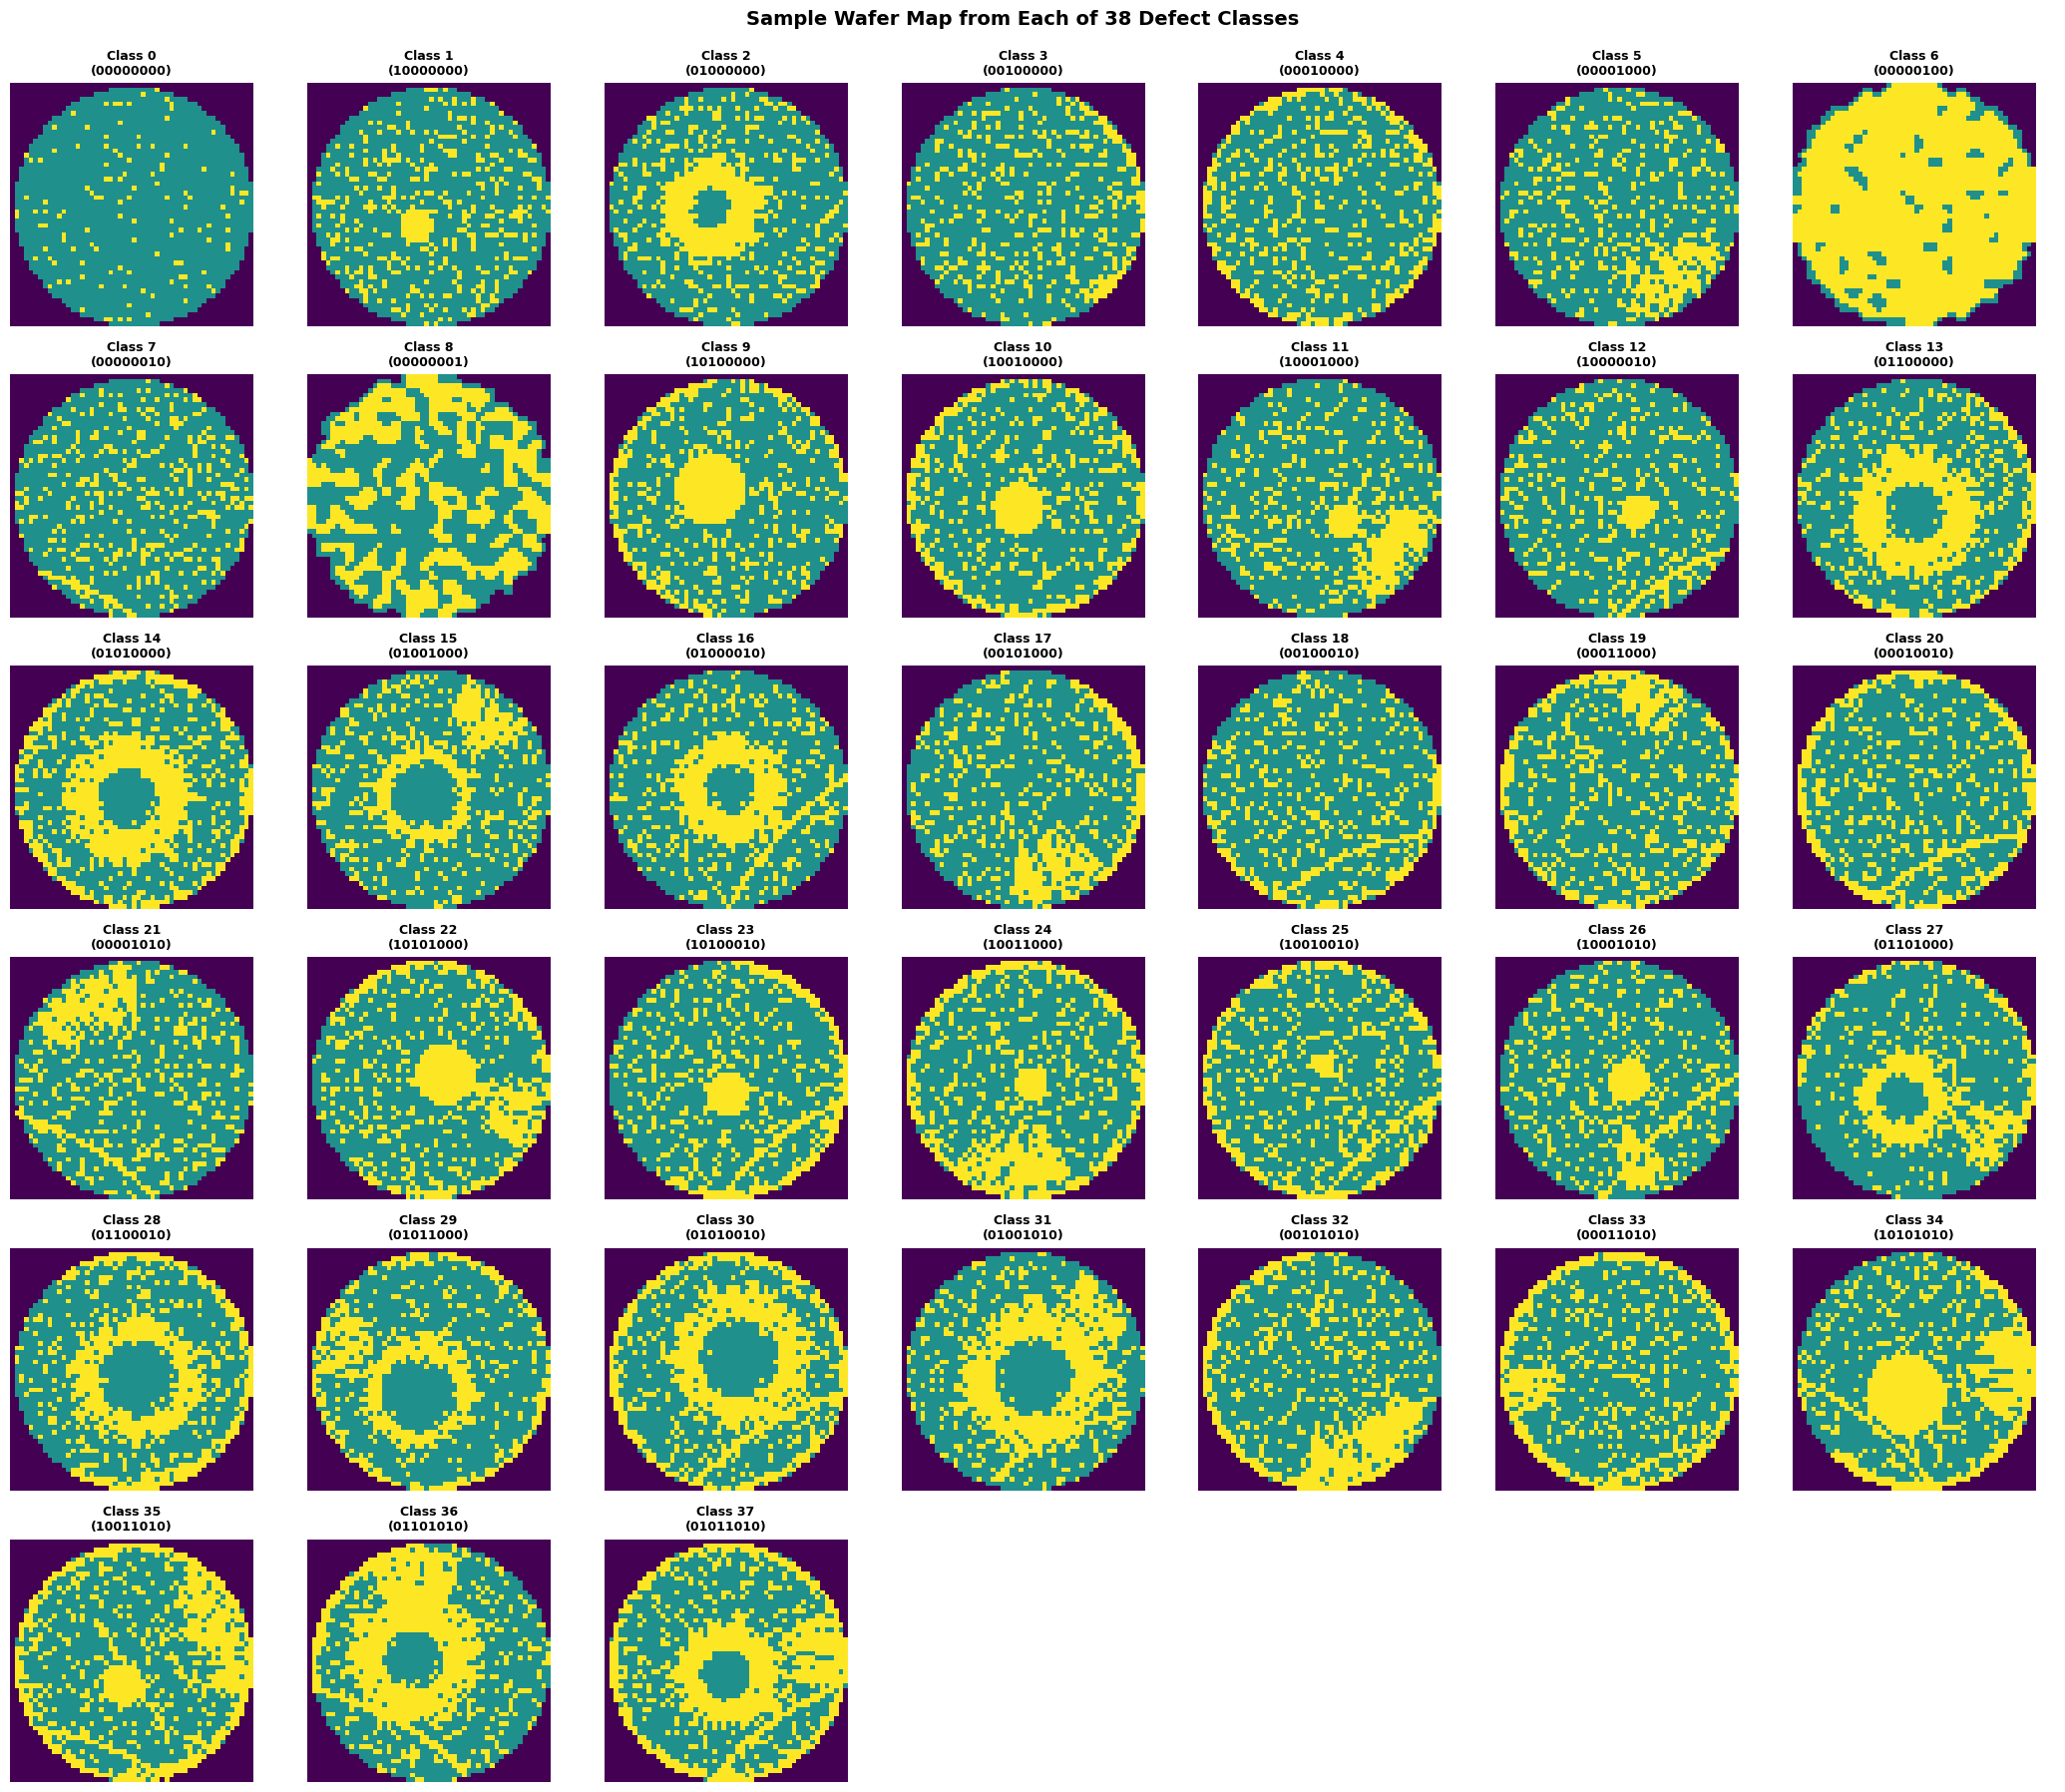

In [5]:
# View sample gallery (one sample per class)
loader.plot_sample_gallery()

## Part 2: Data Preprocessing

Normalize the data and split into train/validation/test sets.

In [6]:
# Extract data and labels
X = loader.X
y = loader.y

print(f"Original data shape: {X.shape}")
print(f"Original labels shape: {y.shape}")

# Normalize data to [0, 1]
X_min = X.min()
X_max = X.max()
X_normalized = (X - X_min) / (X_max - X_min)

print(f"\nNormalization:")
print(f"  Min value: {X_min}")
print(f"  Max value: {X_max}")
print(f"  Normalized range: [{X_normalized.min():.4f}, {X_normalized.max():.4f}]")

Original data shape: (38015, 52, 52)
Original labels shape: (38015,)

Normalization:
  Min value: 0
  Max value: 3
  Normalized range: [0.0000, 1.0000]

Normalization:
  Min value: 0
  Max value: 3
  Normalized range: [0.0000, 1.0000]


In [7]:
# Split data into train/val/test (70/15/15)
from sklearn.model_selection import train_test_split

# First split: train (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_normalized, y, test_size=0.30, random_state=42, stratify=y
)

# Second split: val (15%) and test (15%) from temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print(f"{'='*70}")
print("DATA SPLIT SUMMARY".center(70))
print(f"{'='*70}")
print(f"Training set:   {X_train.shape[0]:6d} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]:6d} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test set:       {X_test.shape[0]:6d} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"Total:          {len(X):6d} samples")
print(f"{'='*70}")

                          DATA SPLIT SUMMARY                          
Training set:    26610 samples (70.0%)
Validation set:   5702 samples (15.0%)
Test set:         5703 samples (15.0%)
Total:           38015 samples


## Part 3: View All Model Configurations

Display the hyperparameter configurations for all available models.

In [8]:
# Print all model configurations
print_all_configs()


                              MODEL CONFIGURATIONS                              

SimpleNN: Simple Neural Network
Description: Single hidden layer fully connected network
Architecture: 2704 -> 38
Training Parameters:
  - learning_rate: 0.001
  - batch_size: 64
  - optimizer: adam
  - num_epochs: 20
  - early_stopping_patience: 5

MLP: Multi-Layer Perceptron
Description: Fully connected network with multiple hidden layers
Architecture: 2704 -> 512 -> 256 -> 128 -> 38
Training Parameters:
  - learning_rate: 0.0005
  - batch_size: 64
  - optimizer: adam
  - num_epochs: 25
  - early_stopping_patience: 5

CNN: Convolutional Neural Network
Description: CNN with 3 convolutional layers and fully connected layers
Architecture: Conv(32) -> Conv(64) -> Conv(128) -> FC(38)
Training Parameters:
  - learning_rate: 0.001
  - batch_size: 64
  - optimizer: adam
  - num_epochs: 20
  - early_stopping_patience: 5

CNNAugmented: CNN with Data Augmentation
Description: CNN trained with data augmentation te

## Part 4: Train Single Model with Configuration

Train a single model using predefined configuration.

In [9]:
# Example: Train Simple Neural Network using configuration
print("\nTraining Simple Neural Network from configuration...\n")

from models import SimpleNN

# Note: SimpleNN class needs to be imported from your models module
result_simple = train_from_config(
     SimpleNN,
     X_train, X_val, X_test,
     y_train, y_val, y_test,
     SIMPLE_NN_CONFIG,
     input_size=2704,
     device=device
 )

# print(f"\nSimple NN Results:")
# print(f"  Train Accuracy: {result_simple['train_acc']:.4f}")
# print(f"  Val Accuracy:   {result_simple['val_acc']:.4f}")
# print(f"  Test Accuracy:  {result_simple['test_acc']:.4f}")


Training Simple Neural Network from configuration...


                   Training: Simple Neural Network                    
Learning Rate: 0.001
Batch Size: 64
Optimizer: adam
Max Epochs: 20
Early Stopping Patience: 5

Model: SimpleNN
Architecture: 2704 -> 38
Total parameters: 102,790

Model structure:
SimpleNN(
  (fc): Linear(in_features=2704, out_features=38, bias=True)
)

Data Loaders:
  Training batches: 416 (batch_size=64)
  Validation batches: 90 (batch_size=64)
  Test batches: 90 (batch_size=64)



Epoch 1/20:
  Train Loss: 2.9585, Train Acc: 0.1688
  Val Loss: 2.5144, Val Acc: 0.2443
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.3358, Train Acc: 0.2908
  Val Loss: 2.2135, Val Acc: 0.3167
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.0722, Train Acc: 0.3563
  Val Loss: 2.1458, Val Acc: 0.3055
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 1.9018, Train Acc: 0.4169
  Val Loss: 2.0298, Val Acc: 0.3420
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 1.7638, Train Acc: 0.4624
  Val Loss: 1.8958, Val Acc: 0.4021
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.6629, Train Acc: 0.4984
  Val Loss: 1.8125, Val Acc: 0.3871
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 1.5582, Train Acc: 0.5424
  Val Loss: 1.7653, Val Acc: 0.3934
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.4867, Train Acc: 0.5629
  Val Loss: 1.6801, Val Acc: 0.4469
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 1.4033, Train Acc: 0.6026
  Val Loss: 1.6750, Val Acc: 0.4446
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 1.3500, Train Acc: 0.6179
  Val Loss: 1.6568, Val Acc: 0.4274
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.2946, Train Acc: 0.6399
  Val Loss: 1.6276, Val Acc: 0.4332
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.2422, Train Acc: 0.6590
  Val Loss: 1.5634, Val Acc: 0.4791
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.1910, Train Acc: 0.6794
  Val Loss: 1.5332, Val Acc: 0.4942
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.1447, Train Acc: 0.6958
  Val Loss: 1.5126, Val Acc: 0.5005
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.1162, Train Acc: 0.6958
  Val Loss: 1.5177, Val Acc: 0.4721
  Patience: 1/5


Epoch 16/20:
  Train Loss: 1.0772, Train Acc: 0.7107
  Val Loss: 1.4888, Val Acc: 0.4982
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.0386, Train Acc: 0.7264
  Val Loss: 1.4758, Val Acc: 0.5021
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.0147, Train Acc: 0.7297
  Val Loss: 1.4598, Val Acc: 0.4944
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 0.9666, Train Acc: 0.7518
  Val Loss: 1.4607, Val Acc: 0.4911
  Patience: 1/5


Epoch 20/20:
  Train Loss: 0.9490, Train Acc: 0.7550
  Val Loss: 1.4903, Val Acc: 0.4769
  Patience: 2/5

Loaded best model with validation loss: 1.4598

TRAINING COMPLETE
Final Train Accuracy: 0.7550
Final Val Accuracy: 0.4769
Test Accuracy: 0.4701
Epochs Trained: 20



## Part 5: Train Multiple Models at Once

Train all models and compare their performance.

In [10]:
# Example: Train multiple models
# models = [SimpleNN, MLP, CNN]
# configs = [SIMPLE_NN_CONFIG, MLP_CONFIG, CNN_CONFIG]

# print("\nTraining multiple models...\n")
# all_results = train_all_models(
#     models,
#     X_train, X_val, X_test,
#     y_train, y_val, y_test,
#     configs,
#     input_size=2704,
#     device=device
# )

# # Display comparison
# print("\nModel Comparison:")
# print(all_results['summary_df'].to_string(index=False))

## Part 6: Hyperparameter Tuning

Find optimal hyperparameters for a model using grid search.

In [ ]:
# Example: Hyperparameter tuning for SimpleNN
from config import SIMPLE_NN_TUNING_GRID

tuning_grid = {
    'learning_rate': [0.001, 0.0005],
    'batch_size': [32, 64],
    'optimizer': ['adam', 'sgd']
}

print("\nPerforming hyperparameter tuning...\n")
tuning_results1 = hyperparameter_tuning(
    SimpleNN,
    X_train, X_val, X_test,
    y_train, y_val, y_test,
    param_grid=tuning_grid,
    input_size=2704,
    num_classes=38,
    device=device,
    num_epochs=10  # Shorter training for tuning
)

# Display best parameters
print(f"\nBest Parameters: {tuning_results1['best_params']}")
print(f"Best Validation Accuracy: {tuning_results1['best_val_acc']:.4f}")
print(f"Test Accuracy of Best Model: {tuning_results1['best_test_acc']:.4f}")

# Top 5 configurations
print(f"\nTop 5 Configurations:")
print(tuning_results1['summary_df'].head(5).to_string(index=False))


Performing hyperparameter tuning...


                  HYPERPARAMETER TUNING: Grid Search                  
Model: SimpleNN
Total combinations to evaluate: 8
Parameters: learning_rate, batch_size, optimizer


[1/8] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/10:
  Train Loss: 2.8604, Train Acc: 0.1845
  Val Loss: 2.4316, Val Acc: 0.2713
  ✓ New best validation loss!


Epoch 2/10:
  Train Loss: 2.2127, Train Acc: 0.3064
  Val Loss: 2.1513, Val Acc: 0.3073
  ✓ New best validation loss!


Epoch 3/10:
  Train Loss: 1.9426, Train Acc: 0.3849
  Val Loss: 2.0469, Val Acc: 0.3360
  ✓ New best validation loss!


Epoch 4/10:
  Train Loss: 1.7562, Train Acc: 0.4464
  Val Loss: 1.8936, Val Acc: 0.3499
  ✓ New best validation loss!


Epoch 5/10:
  Train Loss: 1.6230, Train Acc: 0.4898
  Val Loss: 1.8862, Val Acc: 0.3616
  ✓ New best validation loss!


Epoch 6/10:
  Train Loss: 1.5067, Train Acc: 0.5368
  Val Loss: 1.7914, Val Acc: 0.4197
  ✓ New best validation loss!


Epoch 7/10:
  Train Loss: 1.4035, Train Acc: 0.5728
  Val Loss: 1.7317, Val Acc: 0.4042
  ✓ New best validation loss!


Epoch 8/10:
  Train Loss: 1.3257, Train Acc: 0.6025
  Val Loss: 1.6692, Val Acc: 0.4071
  ✓ New best validation loss!


Epoch 9/10:
  Train Loss: 1.2570, Train Acc: 0.6269
  Val Loss: 1.5831, Val Acc: 0.4649
  ✓ New best validation loss!


Epoch 10/10:
  Train Loss: 1.1924, Train Acc: 0.6466
  Val Loss: 1.6639, Val Acc: 0.4142
  Patience: 1/5

Loaded best model with validation loss: 1.5831
Train Acc: 0.6466 | Val Acc: 0.4142 | Test Acc: 0.4159
✓ NEW BEST! (Val Acc: 0.4142)

[2/8] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/10:
  Train Loss: 3.3488, Train Acc: 0.1143
  Val Loss: 3.1002, Val Acc: 0.1936
  ✓ New best validation loss!


Epoch 2/10:
  Train Loss: 2.9348, Train Acc: 0.2106
  Val Loss: 2.8137, Val Acc: 0.2287
  ✓ New best validation loss!


Epoch 3/10:
  Train Loss: 2.6976, Train Acc: 0.2562
  Val Loss: 2.6343, Val Acc: 0.2553
  ✓ New best validation loss!


Epoch 4/10:
  Train Loss: 2.5339, Train Acc: 0.2928
  Val Loss: 2.5091, Val Acc: 0.2499
  ✓ New best validation loss!


Epoch 5/10:
  Train Loss: 2.4142, Train Acc: 0.3240
  Val Loss: 2.4130, Val Acc: 0.3113
  ✓ New best validation loss!


Epoch 6/10:
  Train Loss: 2.3181, Train Acc: 0.3476
  Val Loss: 2.3312, Val Acc: 0.3090
  ✓ New best validation loss!


Epoch 7/10:
  Train Loss: 2.2384, Train Acc: 0.3758
  Val Loss: 2.2598, Val Acc: 0.3360
  ✓ New best validation loss!


Epoch 8/10:
  Train Loss: 2.1710, Train Acc: 0.3913
  Val Loss: 2.2155, Val Acc: 0.3257
  ✓ New best validation loss!


Epoch 9/10:
  Train Loss: 2.1140, Train Acc: 0.4109
  Val Loss: 2.1629, Val Acc: 0.3627
  ✓ New best validation loss!


Epoch 10/10:
  Train Loss: 2.0600, Train Acc: 0.4340
  Val Loss: 2.1200, Val Acc: 0.3637
  ✓ New best validation loss!

Loaded best model with validation loss: 2.1200
Train Acc: 0.4340 | Val Acc: 0.3637 | Test Acc: 0.3626

[3/8] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/10:
  Train Loss: 2.9511, Train Acc: 0.1736
  Val Loss: 2.5164, Val Acc: 0.2041
  ✓ New best validation loss!


Epoch 2/10:
  Train Loss: 2.3160, Train Acc: 0.2988
  Val Loss: 2.1903, Val Acc: 0.3259
  ✓ New best validation loss!


Epoch 3/10:
  Train Loss: 2.0651, Train Acc: 0.3693
  Val Loss: 2.0485, Val Acc: 0.3513
  ✓ New best validation loss!


Epoch 4/10:
  Train Loss: 1.8950, Train Acc: 0.4212
  Val Loss: 1.9818, Val Acc: 0.3339
  ✓ New best validation loss!


Epoch 5/10:
  Train Loss: 1.7544, Train Acc: 0.4676
  Val Loss: 1.8289, Val Acc: 0.4232
  ✓ New best validation loss!


Epoch 6/10:
  Train Loss: 1.6513, Train Acc: 0.5091
  Val Loss: 1.7839, Val Acc: 0.4200
  ✓ New best validation loss!


Epoch 7/10:
  Train Loss: 1.5525, Train Acc: 0.5456
  Val Loss: 1.7245, Val Acc: 0.4186
  ✓ New best validation loss!


Epoch 8/10:
  Train Loss: 1.4777, Train Acc: 0.5693
  Val Loss: 1.7043, Val Acc: 0.4274
  ✓ New best validation loss!


Epoch 9/10:
  Train Loss: 1.4093, Train Acc: 0.5939
  Val Loss: 1.6764, Val Acc: 0.4291
  ✓ New best validation loss!


Epoch 10/10:
  Train Loss: 1.3541, Train Acc: 0.6151
  Val Loss: 1.6178, Val Acc: 0.4726
  ✓ New best validation loss!

Loaded best model with validation loss: 1.6178
Train Acc: 0.6151 | Val Acc: 0.4726 | Test Acc: 0.4706
✓ NEW BEST! (Val Acc: 0.4726)

[4/8] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/10:
  Train Loss: 3.4705, Train Acc: 0.0861
  Val Loss: 3.3109, Val Acc: 0.1554
  ✓ New best validation loss!


Epoch 2/10:
  Train Loss: 3.1912, Train Acc: 0.1627
  Val Loss: 3.0940, Val Acc: 0.2013
  ✓ New best validation loss!


Epoch 3/10:
  Train Loss: 2.9921, Train Acc: 0.2151
  Val Loss: 2.9196, Val Acc: 0.2199
  ✓ New best validation loss!


Epoch 4/10:
  Train Loss: 2.8420, Train Acc: 0.2449
  Val Loss: 2.7971, Val Acc: 0.2194
  ✓ New best validation loss!


Epoch 5/10:
  Train Loss: 2.7243, Train Acc: 0.2735
  Val Loss: 2.6971, Val Acc: 0.2597
  ✓ New best validation loss!


Epoch 6/10:
  Train Loss: 2.6332, Train Acc: 0.2927
  Val Loss: 2.6121, Val Acc: 0.2834
  ✓ New best validation loss!


Epoch 7/10:
  Train Loss: 2.5523, Train Acc: 0.3118
  Val Loss: 2.5498, Val Acc: 0.2978
  ✓ New best validation loss!


Epoch 8/10:
  Train Loss: 2.4831, Train Acc: 0.3384
  Val Loss: 2.4900, Val Acc: 0.3004
  ✓ New best validation loss!


Epoch 9/10:
  Train Loss: 2.4238, Train Acc: 0.3453
  Val Loss: 2.4420, Val Acc: 0.2938
  ✓ New best validation loss!


Epoch 10/10:
  Train Loss: 2.3717, Train Acc: 0.3607
  Val Loss: 2.3919, Val Acc: 0.3162
  ✓ New best validation loss!

Loaded best model with validation loss: 2.3919
Train Acc: 0.3607 | Val Acc: 0.3162 | Test Acc: 0.2986

[5/8] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/10:
  Train Loss: 3.0073, Train Acc: 0.1693
  Val Loss: 2.6433, Val Acc: 0.1940
  ✓ New best validation loss!


Epoch 2/10:
  Train Loss: 2.4113, Train Acc: 0.2775
  Val Loss: 2.3616, Val Acc: 0.2566
  ✓ New best validation loss!


Epoch 3/10:
  Train Loss: 2.1534, Train Acc: 0.3401
  Val Loss: 2.1323, Val Acc: 0.3492
  ✓ New best validation loss!


Epoch 4/10:
  Train Loss: 1.9821, Train Acc: 0.3962
  Val Loss: 2.0421, Val Acc: 0.3695
  ✓ New best validation loss!


Epoch 5/10:
  Train Loss: 1.8490, Train Acc: 0.4493
  Val Loss: 1.9594, Val Acc: 0.3511
  ✓ New best validation loss!


Epoch 6/10:
  Train Loss: 1.7462, Train Acc: 0.4817
  Val Loss: 1.8941, Val Acc: 0.3953
  ✓ New best validation loss!


Epoch 7/10:
  Train Loss: 1.6556, Train Acc: 0.5219
  Val Loss: 1.8479, Val Acc: 0.4049
  ✓ New best validation loss!


Epoch 8/10:
  Train Loss: 1.5773, Train Acc: 0.5475
  Val Loss: 1.7805, Val Acc: 0.3951
  ✓ New best validation loss!


Epoch 9/10:
  Train Loss: 1.5101, Train Acc: 0.5731
  Val Loss: 1.7256, Val Acc: 0.4106
  ✓ New best validation loss!


Epoch 10/10:
  Train Loss: 1.4458, Train Acc: 0.6000
  Val Loss: 1.6809, Val Acc: 0.4621
  ✓ New best validation loss!

Loaded best model with validation loss: 1.6809
Train Acc: 0.6000 | Val Acc: 0.4621 | Test Acc: 0.4506

[6/8] Testing: {'learning_rate': 0.0005, 'batch_size': 32, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/10:
  Train Loss: 3.4691, Train Acc: 0.0820
  Val Loss: 3.3108, Val Acc: 0.1317
  ✓ New best validation loss!


Epoch 2/10:
  Train Loss: 3.1895, Train Acc: 0.1646
  Val Loss: 3.0851, Val Acc: 0.1585
  ✓ New best validation loss!


Epoch 3/10:
  Train Loss: 2.9905, Train Acc: 0.2090
  Val Loss: 2.9237, Val Acc: 0.2026
  ✓ New best validation loss!


Epoch 4/10:
  Train Loss: 2.8424, Train Acc: 0.2459
  Val Loss: 2.7958, Val Acc: 0.2620
  ✓ New best validation loss!


Epoch 5/10:
  Train Loss: 2.7258, Train Acc: 0.2693
  Val Loss: 2.6978, Val Acc: 0.2418
  ✓ New best validation loss!


Epoch 6/10:
  Train Loss: 2.6295, Train Acc: 0.2922
  Val Loss: 2.6175, Val Acc: 0.2990
  ✓ New best validation loss!


Epoch 7/10:
  Train Loss: 2.5512, Train Acc: 0.3076
  Val Loss: 2.5448, Val Acc: 0.2752
  ✓ New best validation loss!


Epoch 8/10:
  Train Loss: 2.4828, Train Acc: 0.3273
  Val Loss: 2.4831, Val Acc: 0.3192
  ✓ New best validation loss!


Epoch 9/10:
  Train Loss: 2.4225, Train Acc: 0.3462
  Val Loss: 2.4377, Val Acc: 0.3264
  ✓ New best validation loss!


Epoch 10/10:
  Train Loss: 2.3706, Train Acc: 0.3666
  Val Loss: 2.3896, Val Acc: 0.3213
  ✓ New best validation loss!

Loaded best model with validation loss: 2.3896
Train Acc: 0.3666 | Val Acc: 0.3213 | Test Acc: 0.3225

[7/8] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'optimizer': 'adam'}
----------------------------------------------------------------------


Epoch 1/10:
  Train Loss: 3.1197, Train Acc: 0.1520
  Val Loss: 2.7646, Val Acc: 0.2106
  ✓ New best validation loss!


Epoch 2/10:
  Train Loss: 2.5606, Train Acc: 0.2634
  Val Loss: 2.4298, Val Acc: 0.2576
  ✓ New best validation loss!


Epoch 3/10:
  Train Loss: 2.3034, Train Acc: 0.3208
  Val Loss: 2.3030, Val Acc: 0.2627
  ✓ New best validation loss!


Epoch 4/10:
  Train Loss: 2.1367, Train Acc: 0.3696
  Val Loss: 2.1559, Val Acc: 0.2983
  ✓ New best validation loss!


Epoch 5/10:
  Train Loss: 2.0061, Train Acc: 0.4133
  Val Loss: 2.0537, Val Acc: 0.3553
  ✓ New best validation loss!


Epoch 6/10:
  Train Loss: 1.9143, Train Acc: 0.4396
  Val Loss: 1.9840, Val Acc: 0.3927
  ✓ New best validation loss!


Epoch 7/10:
  Train Loss: 1.8247, Train Acc: 0.4741
  Val Loss: 1.9103, Val Acc: 0.4300
  ✓ New best validation loss!


Epoch 8/10:
  Train Loss: 1.7498, Train Acc: 0.5059
  Val Loss: 1.8864, Val Acc: 0.3909
  ✓ New best validation loss!


Epoch 9/10:
  Train Loss: 1.6801, Train Acc: 0.5343
  Val Loss: 1.8369, Val Acc: 0.4220
  ✓ New best validation loss!


Epoch 10/10:
  Train Loss: 1.6242, Train Acc: 0.5502
  Val Loss: 1.7859, Val Acc: 0.4591
  ✓ New best validation loss!

Loaded best model with validation loss: 1.7859
Train Acc: 0.5502 | Val Acc: 0.4591 | Test Acc: 0.4506

[8/8] Testing: {'learning_rate': 0.0005, 'batch_size': 64, 'optimizer': 'sgd'}
----------------------------------------------------------------------


Epoch 1/10:
  Train Loss: 3.5389, Train Acc: 0.0629
  Val Loss: 3.4526, Val Acc: 0.0972
  ✓ New best validation loss!


Epoch 2/10:
  Train Loss: 3.3740, Train Acc: 0.1023
  Val Loss: 3.3033, Val Acc: 0.1291
  ✓ New best validation loss!


Epoch 3/10:
  Train Loss: 3.2358, Train Acc: 0.1516
  Val Loss: 3.1843, Val Acc: 0.1936
  ✓ New best validation loss!


Epoch 4/10:
  Train Loss: 3.1212, Train Acc: 0.1896
  Val Loss: 3.0751, Val Acc: 0.1903
  ✓ New best validation loss!


Epoch 5/10:
  Train Loss: 3.0223, Train Acc: 0.2132
  Val Loss: 2.9897, Val Acc: 0.1980
  ✓ New best validation loss!


Epoch 6/10:
  Train Loss: 2.9389, Train Acc: 0.2357
  Val Loss: 2.9154, Val Acc: 0.1992
  ✓ New best validation loss!


Epoch 7/10:
  Train Loss: 2.8659, Train Acc: 0.2475
  Val Loss: 2.8501, Val Acc: 0.2461
  ✓ New best validation loss!


Epoch 8/10:
  Train Loss: 2.8008, Train Acc: 0.2652
  Val Loss: 2.7898, Val Acc: 0.2455
  ✓ New best validation loss!


Epoch 9/10:
  Train Loss: 2.7424, Train Acc: 0.2803
  Val Loss: 2.7378, Val Acc: 0.2515
  ✓ New best validation loss!


Epoch 10/10:
  Train Loss: 2.6916, Train Acc: 0.2897
  Val Loss: 2.6924, Val Acc: 0.2608
  ✓ New best validation loss!

Loaded best model with validation loss: 2.6924
Train Acc: 0.2897 | Val Acc: 0.2608 | Test Acc: 0.2490

                        TUNING RESULTS SUMMARY                        

Top 5 Configurations:
 Rank  learning_rate  batch_size optimizer  Train_Acc  Val_Acc  Test_Acc  Epochs  Params
    1         0.0010          64      adam   0.615107 0.472641  0.470629      10  102790
    2         0.0005          32      adam   0.600000 0.462119  0.450640      10  102790
    3         0.0005          64      adam   0.550169 0.459137  0.450640      10  102790
    4         0.0010          32      adam   0.646599 0.414241  0.415921      10  102790
    5         0.0010          32       sgd   0.433972 0.363732  0.362616      10  102790

BEST CONFIGURATION:
  learning_rate: 0.001
  batch_size: 64
  optimizer: adam

Best Validation Accuracy: 0.4726
Test Accuracy (Best Model): 0.4706



TypeError: SimpleNN.forward() takes 2 positional arguments but 3 were given

## Part 7: Training History Visualization

Plot training and validation metrics over epochs.

In [ ]:
# Example: Visualize training history
# plot_training_history(result_simple['history'], title='Simple Neural Network')

## Part 8: Custom Training Workflow

For advanced users: customize training with specific hyperparameters.

In [13]:
# Step 1: Create custom configuration
# custom_config = {
#     'name': 'Custom CNN',
#     'architecture': 'Conv(32) -> Conv(64) -> Conv(128) -> FC(38)',
#     'training': {
#         'learning_rate': 0.0005,
#         'batch_size': 32,
#         'optimizer': 'adam',
#         'num_epochs': 30,
#         'early_stopping_patience': 7,
#     },
#     'model_kwargs': {}
# }

# Step 2: Train with custom config
# result_custom = train_from_config(
#     CNN,
#     X_train, X_val, X_test,
#     y_train, y_val, y_test,
#     custom_config,
#     input_size=2704,
#     device=device
# )

# print(f"\nCustom CNN Results:")
# print(f"  Test Accuracy: {result_custom['test_acc']:.4f}")

## Part 9: Model Comparison Summary

Create a comprehensive comparison table of all trained models.

In [14]:
# Example: Compare multiple model results
# comparison_data = {
#     'Model': ['Simple NN', 'MLP', 'CNN', 'Custom CNN'],
#     'Train Acc': [
#         result_simple['train_acc'],
#         result_mlp['train_acc'],
#         result_cnn['train_acc'],
#         result_custom['train_acc']
#     ],
#     'Val Acc': [
#         result_simple['val_acc'],
#         result_mlp['val_acc'],
#         result_cnn['val_acc'],
#         result_custom['val_acc']
#     ],
#     'Test Acc': [
#         result_simple['test_acc'],
#         result_mlp['test_acc'],
#         result_cnn['test_acc'],
#         result_custom['test_acc']
#     ]
# }

# comparison_df = pd.DataFrame(comparison_data)
# print("\nModel Comparison Summary:")
# print(comparison_df.to_string(index=False))

# # Visualize
# fig, ax = plt.subplots(figsize=(10, 6))
# x = np.arange(len(comparison_df))
# width = 0.25
# ax.bar(x - width, comparison_df['Train Acc'], width, label='Train', alpha=0.8)
# ax.bar(x, comparison_df['Val Acc'], width, label='Val', alpha=0.8)
# ax.bar(x + width, comparison_df['Test Acc'], width, label='Test', alpha=0.8)
# ax.set_xlabel('Model')
# ax.set_ylabel('Accuracy')
# ax.set_title('Model Performance Comparison')
# ax.set_xticks(x)
# ax.set_xticklabels(comparison_df['Model'])
# ax.legend()
# ax.set_ylim([0, 1.0])
# plt.tight_layout()
# plt.show()

## Part 10: Next Steps

### Workflow Summary:

1. ✅ **Data Loading**: Load and explore wafer defect dataset
2. ✅ **Preprocessing**: Normalize and split data
3. ✅ **View Configs**: Check all available model configurations
4. ✅ **Train Models**: Use `train_from_config()` for single model or `train_all_models()` for multiple
5. ✅ **Hyperparameter Tuning**: Use `hyperparameter_tuning()` to find optimal parameters
6. ✅ **Evaluate**: Compare models and visualize results

### Key Functions:

| Function | Purpose |
|----------|----------|
| `train_from_config()` | Train single model with config |
| `train_all_models()` | Train multiple models and compare |
| `hyperparameter_tuning()` | Grid search for optimal hyperparameters |
| `setup_model_and_loaders()` | Initialize model and data loaders |
| `plot_training_history()` | Visualize training metrics |

### Key Configuration Files:

- **config.py**: Model configurations and hyperparameter grids
- **utility.py**: Training and evaluation functions
- **data_loading.py**: Data loading and visualization

### To Run This Workflow:

1. Uncomment the code examples in Parts 4-9
2. Ensure your model classes are imported properly
3. Run cells sequentially
4. Modify configurations as needed for your experiments